In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/housesalesprediction/kc_house_data.csv


In [3]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import math
from scipy.stats import pearsonr

In [4]:
df = pd.read_csv('/kaggle/input/housesalesprediction/kc_house_data.csv')

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
df.shape

(21613, 21)

In [7]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [9]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [15]:
# checking the categorical features
df.select_dtypes(include = ['object']).columns.tolist()

['date']

In [18]:
# check any null value
print(df.isnull().any().sum())
print(df.isnull().any(axis = 1).sum())

0
0


In [20]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [26]:
features = df.iloc[:, 3:].columns.tolist()
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [28]:
target = df.iloc[:,2].name
target

'price'

In [44]:
# correlation
correlations = {}
for f in features:
    data_temp = df[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [47]:
df_correlations = pd.DataFrame(correlations, index = ['Value']).T
df_correlations.loc[df_correlations['Value'].abs().sort_values(ascending = False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


In [52]:
# top 5 features are the most correlated features
y = df.loc[:, ['sqft_living', 'grade', target]].sort_values(target, ascending = True).values
x = np.arange(y.shape[0])

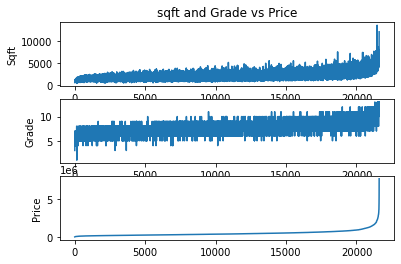

In [54]:
%matplotlib inline
plt.subplot(3, 1, 1)
plt.plot(x, y[:, 0])
plt.title('sqft and Grade vs Price')
plt.ylabel('Sqft')

plt.subplot(3,1, 2)
plt.plot(x, y[:, 1])
plt.ylabel('Grade')

plt.subplot(3, 1, 3)
plt.plot(x, y[:, 2])
plt.ylabel('Price')

plt.show()

In [56]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

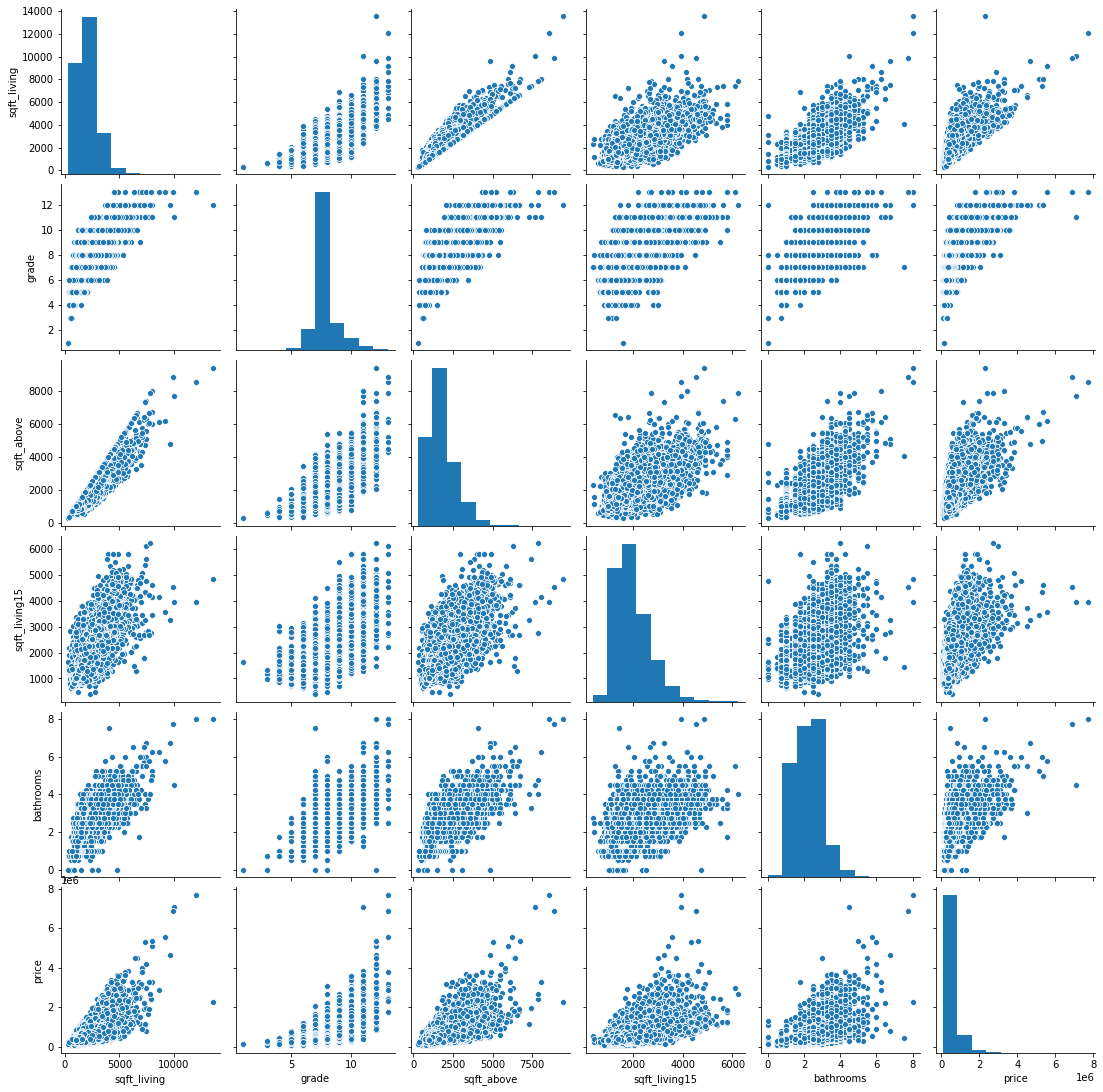

In [59]:
sns.pairplot(df[['sqft_living', 'grade','sqft_above','sqft_living15','bathrooms', 'price' ]])

## Predicting house sales Prices

In [62]:
from sklearn.model_selection import train_test_split

In [64]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [72]:
X = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']].values
y = df.price.values

In [71]:
df.view.unique()

array([0, 3, 4, 2, 1])

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection, tree, linear_model

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [81]:
Linearmodel = LinearRegression()
Linearmodel.fit(X_train, y_train)
linear_pred = Linearmodel.predict(X_test)


In [82]:
Linearmodel.score(X_test, y_test)

0.6754184842408052

In [85]:
# calculate the root mean squared error
print('RMSE: %.2f' % math.sqrt(np.mean((linear_pred - y_test)**2)))

RMSE: 211408.67


In [89]:
# the error is too much so lets try xgboost
xgb = xgboost.XGBRegressor(n_estimators = 100, learning_rate = 0.08, gamma = 0, subsample = 0.75,
                          colsample_bytree = 1, max_depth = 7)

In [90]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.75, tree_method=None,
             validate_parameters=False, verbosity=None)

In [91]:
xgb_pred = xgb.predict(X_test)

In [97]:
print('xgb RMSE: %.2f' % math.sqrt(np.mean((xgb_pred-y_test)**2)))
print('linear RMSE: %.2f' % math.sqrt(np.mean((linear_pred - y_test)**2)))

xgb RMSE: 131243.80
linear RMSE: 211408.67


In [95]:
from sklearn.metrics import explained_variance_score

In [98]:
print('xgb: ',explained_variance_score(xgb_pred, y_test))
print('linear: ', explained_variance_score(linear_pred, y_test))

xgb:  0.8666853967286274
linear:  0.49646617906347046


In [100]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [108]:
xgb_ypred = pd.DataFrame(xgb_pred, columns = ['price'])
xgb_ypred.head()
xgb_ypred.to_csv('submission.csv', index = False)